# X Education Lead Scoring – Logistic Regression
This notebook builds a lead scoring model (0–100) and tunes the prioritization threshold to achieve ~80% conversion in the prioritized pool.

**Key additions:**
- Feature importance (coefficients)
- Multicollinearity check using VIF (on top drivers)
- Threshold tuning to align with ~80% conversion target


In [3]:
import os, zipfile, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Path to dataset (already extracted in this environment)
data_path = r"C:\Users\MANISH SHUKLA\Downloads\ded03f4f-6db1-468b-b4fd-16e5a6763385-Lead-Scoring-Case-Study (2)\Lead Scoring Assignment\Leads.csv"
df = pd.read_csv(data_path)
df.head()


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


## 1) Data overview & target distribution

In [4]:
df.shape, df.columns

((9240, 37),
 Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
        'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
        'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
        'Country', 'Specialization', 'How did you hear about X Education',
        'What is your current occupation',
        'What matters most to you in choosing a course', 'Search', 'Magazine',
        'Newspaper Article', 'X Education Forums', 'Newspaper',
        'Digital Advertisement', 'Through Recommendations',
        'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
        'Update me on Supply Chain Content', 'Get updates on DM Content',
        'Lead Profile', 'City', 'Asymmetrique Activity Index',
        'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
        'Asymmetrique Profile Score',
        'I agree to pay the amount through cheque',
        'A free copy of Mastering The Interview', 'Last Notable Activity'],
     

In [5]:
df['Converted'].value_counts(normalize=True)

Converted
0    0.61461
1    0.38539
Name: proportion, dtype: float64

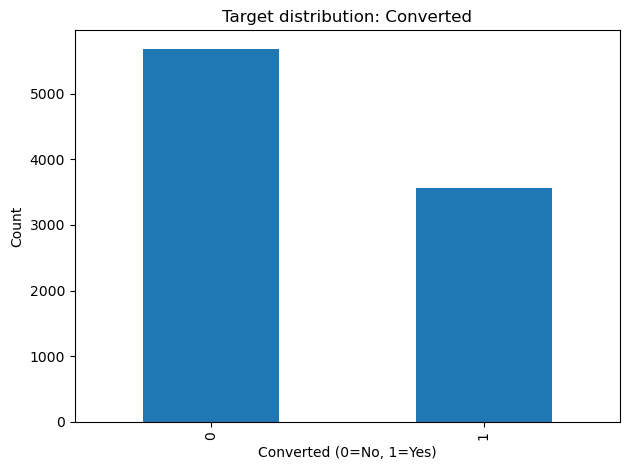

In [6]:
plt.figure()
df['Converted'].value_counts().sort_index().plot(kind='bar')
plt.title("Target distribution: Converted")
plt.xlabel("Converted (0=No, 1=Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## 2) Cleaning: handle 'Select' as missing, drop high-missing columns

In [7]:
df_clean=df.copy()

# Treat 'Select' as missing in categorical columns
obj_cols=df_clean.select_dtypes(include='object').columns
for c in obj_cols:
    df_clean[c]=df_clean[c].replace('Select', np.nan)

# Drop identifiers
drop_cols=['Prospect ID','Lead Number']
df_clean=df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])

y=df_clean['Converted'].astype(int)
X=df_clean.drop(columns=['Converted'])

# Missingness
miss=X.isna().mean().sort_values(ascending=False)
high_missing=miss[miss>0.40].index.tolist()
high_missing


['How did you hear about X Education',
 'Lead Profile',
 'Lead Quality',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Score',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score']

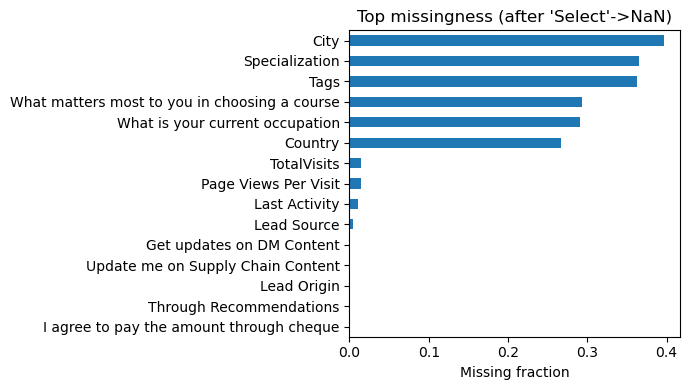

In [8]:
X2=X.drop(columns=high_missing)
miss2=X2.isna().mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(7,4))
miss2[::-1].plot(kind='barh')
plt.title("Top missingness (after 'Select'->NaN)")
plt.xlabel("Missing fraction")
plt.tight_layout()
plt.show()


## 3) Train/Validation/Test split & preprocessing

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

num_cols=X2.select_dtypes(include=[np.number]).columns.tolist()
cat_cols=[c for c in X2.columns if c not in num_cols]

X_train, X_temp, y_train, y_temp = train_test_split(X2, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

numeric_transformer=Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer=Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
])

preprocess=ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

model=Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=3000, solver="lbfgs"))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalVisits',
                                                   'Total Time Spent on '
                                                   'Website',
                                                   'Page Views Per Visit']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknow...
                                                   'Newspaper Article',
                                                   'X Education Forums',
                                                   'Newspaper',
                                                   'Digital Advertisement',
                                                   'Through Recommendations',
                                                   'Receive More Updates About '
                                                   'Our Courses',
                                                   'Tags',
                                                   'Update me on Supply Chain '
                                                   'Content',
                                                   'Get updates on DM Content',
                                                   'City',
                                                   'I agree to pay the amount '
                                                   'through cheque',
                                                   'A free copy of Mastering '
                                                   'The Interview',
                                                   'Last Notable Activity'])])),
                ('clf', LogisticRegression(max_iter=3000))])

## 4) Threshold tuning to meet ~80% conversion target
We tune the cutoff so that **precision ≈ 0.80** on validation data (precision ≈ conversion rate among predicted hot leads).

In [10]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

val_proba = model.predict_proba(X_val)[:,1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)

prec_t, rec_t, thr_t = prec[1:], rec[1:], thr  # align to thresholds
target = 0.80
idx = int(np.argmin(np.abs(prec_t - target)))
best_thr = float(thr_t[idx])
best_thr, float(prec_t[idx]), float(rec_t[idx])


C:\Users\MANISH SHUKLA\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.28864351978214897, 0.8040540540540541, 0.8913857677902621)

In [11]:
# Evaluate on test
test_proba = model.predict_proba(X_test)[:,1]
y_pred = (test_proba >= best_thr).astype(int)

metrics = {
    "accuracy": (y_pred==y_test.values).mean(),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, test_proba),
    "pr_auc": average_precision_score(y_test, test_proba)
}
metrics


C:\Users\MANISH SHUKLA\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{'accuracy': 0.8686868686868687,
 'precision': 0.7741433021806854,
 'recall': 0.9307116104868914,
 'f1': 0.8452380952380952,
 'roc_auc': 0.9521087197341352,
 'pr_auc': 0.9278569385124995}

## 5) Visual evaluation (ROC, PR, confusion matrix)

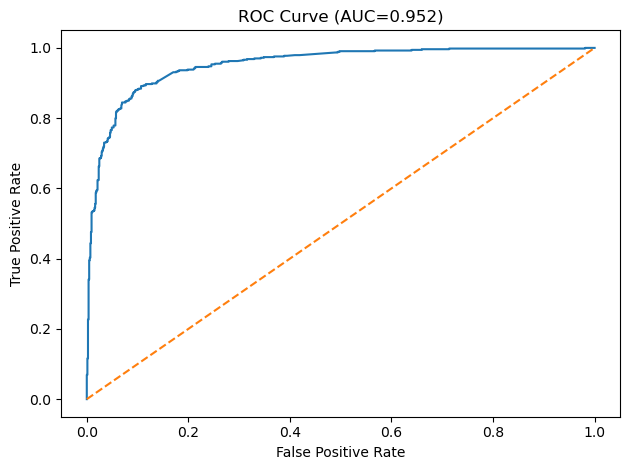

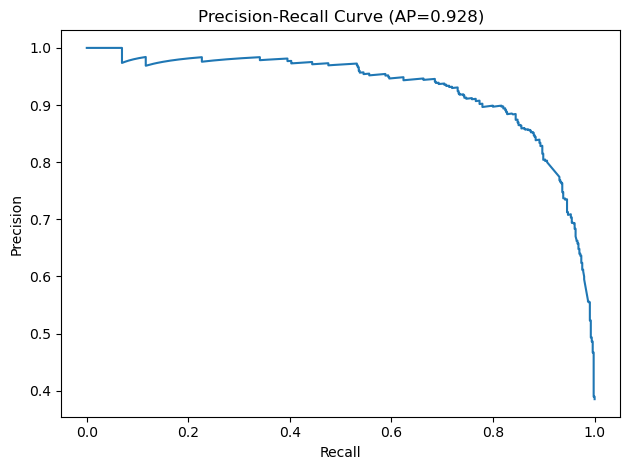

<Figure size 640x480 with 0 Axes>

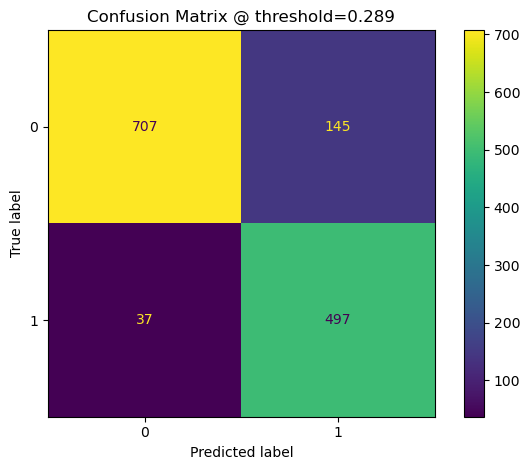

In [12]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.title(f"ROC Curve (AUC={metrics['roc_auc']:.3f})")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.tight_layout(); plt.show()

prec_curve, rec_curve, _ = precision_recall_curve(y_test, test_proba)
plt.figure()
plt.plot(rec_curve, prec_curve)
plt.title(f"Precision-Recall Curve (AP={metrics['pr_auc']:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure()
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title(f"Confusion Matrix @ threshold={best_thr:.3f}")
plt.tight_layout(); plt.show()


## 6) Feature importance (coefficients)
We extract feature names from the preprocessing step and show the top coefficients by absolute value.

In [13]:
# Extract encoded feature names
preprocess_fitted = model.named_steps["preprocess"]
ohe = preprocess_fitted.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)

coefs = model.named_steps["clf"].coef_[0]
coef_s = pd.Series(coefs, index=feature_names).sort_values(key=np.abs, ascending=False)

coef_s.head(20)


Tags_Lost to EINS                                       6.170405
Tags_Closed by Horizzon                                 6.061609
Tags_Will revert after reading the email                2.587531
Lead Origin_Lead Add Form                               2.428892
Tags_switched off                                      -2.008429
Tags_Busy                                               1.904355
Tags_Ringing                                           -1.870569
What is your current occupation_Working Professional    1.336651
What is your current occupation_Unemployed             -1.326332
Lead Source_Welingak Website                            1.307843
Last Notable Activity_Had a Phone Conversation          1.302002
Last Notable Activity_SMS Sent                          1.257890
Tags_invalid number                                    -1.230090
Last Notable Activity_Modified                         -1.226448
Do Not Email_Yes                                       -1.210931
Tags_number not provided 

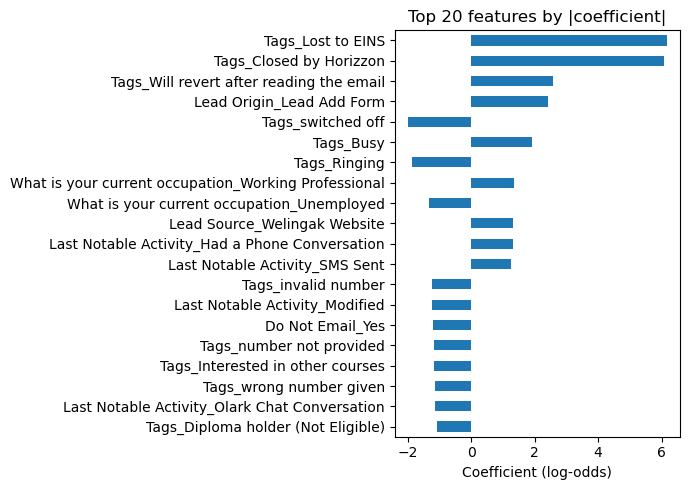

In [14]:
top20 = coef_s.head(20)[::-1]
plt.figure(figsize=(7,5))
top20.plot(kind='barh')
plt.title("Top 20 features by |coefficient|")
plt.xlabel("Coefficient (log-odds)")
plt.tight_layout()
plt.show()


## 7) VIF analysis (top drivers)
Computing VIF for all one-hot features can be heavy. We compute VIF for a reduced set (numeric + top influential encoded features).

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Build full design matrix for train+val
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

X_mat = preprocess_fitted.transform(X_trainval)
X_mat = pd.DataFrame(X_mat, columns=feature_names)

top_features = list(coef_s.head(35).index)
vif_features = list(dict.fromkeys(num_cols + top_features))
X_vif = X_mat[vif_features]

vif_vals = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_table = pd.DataFrame({"feature": X_vif.columns, "VIF": vif_vals}).sort_values("VIF", ascending=False)
vif_table.head(15)


C:\Users\MANISH SHUKLA\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,feature,VIF
11,What is your current occupation_Unemployed,12.055747
5,Tags_Will revert after reading the email,7.888483
9,Tags_Ringing,2.634705
16,Last Notable Activity_Modified,2.618829
10,What is your current occupation_Working Profes...,2.129496
14,Last Notable Activity_SMS Sent,1.854459
17,Do Not Email_Yes,1.819565
27,Last Activity_Olark Chat Conversation,1.778761
6,Lead Origin_Lead Add Form,1.772875
34,Last Activity_Email Bounced,1.752778


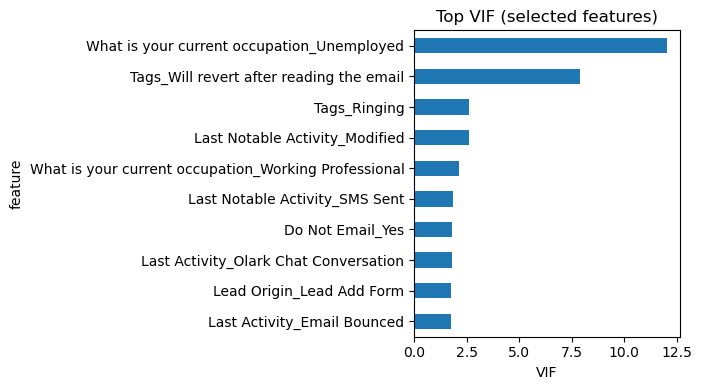

In [17]:
plt.figure(figsize=(7,4))
vif_table.head(10).iloc[::-1].set_index("feature")["VIF"].plot(kind='barh')
plt.title("Top VIF (selected features)")
plt.xlabel("VIF")
plt.tight_layout()
plt.show()


## 8) Lead scoring (0–100) and export

In [21]:
# Score full dataset
full_proba = model.predict_proba(X2)[:,1]
scored = df_clean.copy()
scored["Pred_Prob"] = full_proba
scored["Lead_Score"] = np.round(full_proba*100, 2)

out_path = r"C:\Users\MANISH SHUKLA\Downloads\ded03f4f-6db1-468b-b4fd-16e5a6763385-Lead-Scoring-Case-Study (2)\Lead Scoring Assignment\Leads.csv"
scored.to_csv(out_path, index=False)
out_path, scored[["Pred_Prob","Lead_Score"]].describe()


C:\Users\MANISH SHUKLA\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


('C:\\Users\\MANISH SHUKLA\\Downloads\\ded03f4f-6db1-468b-b4fd-16e5a6763385-Lead-Scoring-Case-Study (2)\\Lead Scoring Assignment\\Leads.csv',
          Pred_Prob   Lead_Score
 count  9240.000000  9240.000000
 mean      0.385869    38.586799
 std       0.389753    38.974984
 min       0.000086     0.010000
 25%       0.026448     2.647500
 50%       0.217470    21.750000
 75%       0.822260    82.230000
 max       0.999985   100.000000)